In [1]:
#Import libraries:
import pandas as pd
import numpy as np
from numpy import mean
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn import model_selection
from sklearn.ensemble import ExtraTreesRegressor,GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import GridSearchCV,learning_curve
from sklearn.metrics import make_scorer,explained_variance_score,r2_score,make_scorer
from sklearn.metrics import mean_squared_error,accuracy_score,mean_absolute_error,accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [2]:
#importation du jeu de donnée preparé
df=pd.read_csv('predPrpo.csv', sep=';',index_col=0)
df.head()
#découpage du jeu de donnée pour isoler la target
target=np.log(df.SalePrice)
feats=df.drop('SalePrice', axis=1)
X_train,X_test,y_train,y_test=train_test_split(feats,target,test_size=0.2)

In [3]:
#on  prépare la  configuration pour la méthode de  cross validation 
seed = 42
# prepare models
models = []
models.append(('ETR',ExtraTreesRegressor()))
models.append(('GBR',GradientBoostingRegressor()))
models.append(('CBR',CatBoostRegressor()))
models.append(('RFR',RandomForestRegressor()))
models.append(('XGBR',XGBRegressor()))
models.append(('LR',LinearRegression()))
#labels = ['GB', 'RF', 'XGB', 'LR','SVM']
# evaluer  chaque modèle 
results = []
names = []
x=[1,2,3,4,5,6]

ETR: 0.459832 (0.055016)
GBR: 0.458190 (0.055803)
Learning rate set to 0.046039
0:	learn: 0.2927173	total: 172ms	remaining: 2m 51s
1:	learn: 0.2880344	total: 176ms	remaining: 1m 27s
2:	learn: 0.2834274	total: 178ms	remaining: 59.3s
3:	learn: 0.2789082	total: 182ms	remaining: 45.4s
4:	learn: 0.2749341	total: 185ms	remaining: 36.8s
5:	learn: 0.2712122	total: 189ms	remaining: 31.3s
6:	learn: 0.2672883	total: 192ms	remaining: 27.2s
7:	learn: 0.2639330	total: 195ms	remaining: 24.2s
8:	learn: 0.2609114	total: 198ms	remaining: 21.7s
9:	learn: 0.2579753	total: 201ms	remaining: 19.9s
10:	learn: 0.2548507	total: 204ms	remaining: 18.3s
11:	learn: 0.2520662	total: 207ms	remaining: 17s
12:	learn: 0.2492488	total: 209ms	remaining: 15.9s
13:	learn: 0.2467661	total: 214ms	remaining: 15.1s
14:	learn: 0.2445991	total: 216ms	remaining: 14.2s
15:	learn: 0.2427021	total: 220ms	remaining: 13.5s
16:	learn: 0.2406993	total: 222ms	remaining: 12.8s
17:	learn: 0.2386150	total: 225ms	remaining: 12.3s
18:	learn: 0

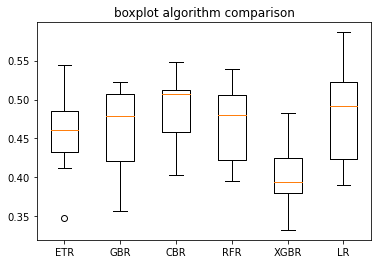

In [4]:
#Visualisation des resultats en fonction des modèles
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed,shuffle=True)
    cv_results = model_selection.cross_val_score(model, X_train, y_train,
                                                 cv=kfold)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
plt.boxplot(results)
plt.xticks(x, names)
plt.title('boxplot algorithm comparison')
plt.show()

In [5]:
#fonction permettant de calculer différents score
def scoring(modelFit):
    y_test_predictions=modelFit.predict(X_test)
    print("score test sans optimiser les paramètres : %.2g" % modelFit.score(X_test, y_test))
    print('Mean Absolute Error(MAE):', mean_absolute_error(y_test, y_test_predictions))
    print('Mean Squared Error(MSE):', mean_squared_error(y_test, y_test_predictions))
    print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, y_test_predictions)))
    print('Explained Variance Score (EVS):',explained_variance_score(y_test,y_test_predictions))
    print('R2:',r2_score(y_test, y_test_predictions))

    y_train_predictions=modelFit.predict(X_train)
    print("score train sans optimiser les paramètres : %.2g" % modelFit.score(X_train, y_train))

In [21]:
from matplotlib.legend_handler import HandlerLine2D

def visual_score(n_estimator,train_results,test_results,title,estimators):
    line1,=plt.plot(n_estimator,train_results,'b',label='Train score')
    line2,=plt.plot(n_estimator,test_results,'r',label='Test score')
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('score')
    plt.xlabel(estimators)
    plt.title(title)
    plt.show()

In [8]:
#test du modèle sans optimisation
def test_model(model_test,title):
    # parametres par defaut
    model=model_test
    model.fit(X_train, y_train)
    # feature importance
    print(model.feature_importances_)
    importance=model.feature_importances_
    #plot Feature Importances
    feat_imp = pd.Series(model.feature_importances_[:20], feats.columns[:20]).sort_values(ascending=False)
    plt.figure(figsize=(12,12))
    feat_imp.plot(kind='bar')
    plt.xticks(rotation=45)
    plt.ylabel('Feature Importance Score ')
    plt.title(title)
    plt.show()
    scoring(model)

In [9]:
#optimiser n_estimators
def optimise_n_estimator(estimator):
    param_test={'n_estimators':range(10,850,20)}

    gsearch=GridSearchCV(estimator=estimator, 
    param_grid=param_test,n_jobs=4,cv=5).fit(X_train,y_train)

    print(gsearch.best_params_)
    scoring(gsearch)

In [20]:
#Visualiser l'evolution de n_estimators
def visual_estimator(estimator_op,title,estimators):
    n_estimators=[int(x) for x in np.linspace(10,800,num=50)]
    train_results= []
    test_results= []
    for estimator in n_estimators:
        model=estimator_op(n_estimators=estimator)
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        train_score=model.score(X_train,y_train)
        train_results.append(train_score)
        y_pred = model.predict(X_test)
        test_score=model.score(X_test,y_test)
        test_results.append(test_score)
    visual_score(n_estimators,train_results,test_results,title,estimators)

In [26]:
def visual_learning(model,title,est,estimators):
    learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
    train_results = []
    test_results = []
    for eta in learning_rates:
        model3=model(learning_rate=eta,n_estimators=est)
        model3.fit(X_train, y_train)
        train_pred = model3.predict(X_train)
        train_results.append(model3.score(X_train,y_train))
        y_pred = model3.predict(X_test)
        test_results.append(model3.score(X_test,y_test))
    visual_score(learning_rates,train_results,test_results,title,estimators)

In [12]:
from sklearn.model_selection import RandomizedSearchCV

#optimiser les hyperparametres
def opt_param(model_op,random_grid):
    model=RandomizedSearchCV(estimator=model_op,param_distributions=random_grid,
                                 n_iter=100,cv=5,verbose=2,random_state=35,n_jobs=-1)
    model.fit(X_train,y_train)
    scoring(model)
    print(model.best_params_)
    return model.best_params_

[8.52262977e-03 1.15709661e-02 1.22555308e-02 2.38427129e-02
 1.95651974e-04 3.92843581e-03 1.00771419e-02 7.35331651e-03
 6.46054095e-05 7.54423367e-03 5.74591242e-03 9.75796603e-03
 6.86583144e-03 2.33164253e-03 6.42938378e-03 3.81116951e-03
 8.09966094e-02 1.29519155e-02 7.15241750e-03 1.59431582e-03
 9.51742673e-03 8.92673560e-03 7.21830474e-03 8.30429224e-03
 3.91482511e-02 5.58445783e-03 5.33311202e-03 9.76181963e-03
 5.79192246e-03 8.09689636e-03 8.23053019e-03 1.26307693e-02
 3.41910388e-03 2.85828708e-03 1.18650935e-02 2.06436675e-02
 1.23483974e-02 8.78982758e-03 7.13646522e-03 7.04437626e-03
 1.95843192e-02 1.18880158e-02 1.64662570e-03 1.00001797e-01
 6.19696699e-03 1.88739721e-03 6.91056506e-02 6.53266397e-03
 2.41392078e-02 1.54373142e-03 2.87456988e-02 3.29016478e-02
 8.12141488e-03 8.03475523e-03 1.67603857e-02 6.69197574e-03
 1.75608128e-02 4.39836269e-02 2.07474233e-02 6.37844273e-03
 9.94181954e-03 6.27935666e-03 9.44073154e-03 1.59617445e-02
 4.99701114e-03 1.236344

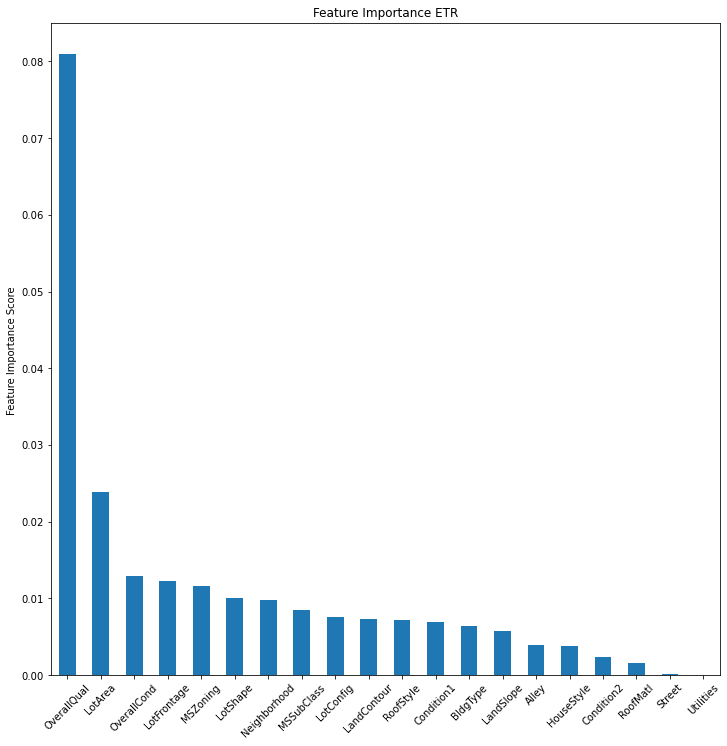

score test sans optimiser les paramètres : 0.43
Mean Absolute Error(MAE): 0.15186850540893213
Mean Squared Error(MSE): 0.04093132321721563
Root Mean Squared Error (RMSE): 0.20231491101057192
Explained Variance Score (EVS): 0.4314438850550494
R2: 0.431318077567834
score train sans optimiser les paramètres : 1


In [13]:
#ExtraTreesRegressor test modèle
model=ExtraTreesRegressor()
title='Feature Importance ETR'

test_model(model,title)

In [14]:
#ExtraTreesRegressor best n_estimators
ETR=ExtraTreesRegressor()

optimise_n_estimator(ETR)

{'n_estimators': 630}
score test sans optimiser les paramètres : 0.43
Mean Absolute Error(MAE): 0.1523145176202273
Mean Squared Error(MSE): 0.04098428093143272
Root Mean Squared Error (RMSE): 0.20244574811892868
Explained Variance Score (EVS): 0.43070776818306944
R2: 0.4305823062230191
score train sans optimiser les paramètres : 1


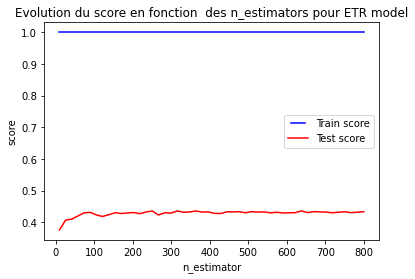

In [22]:
#ExtraTreesRegressor visualisation du score en fonction de n_estimators
ETR_op=ExtraTreesRegressor
title1='Evolution du score en fonction  des n_estimators pour ETR model'
n_esmistor='n_estimator'

visual_estimator(ETR_op,title1,n_esmistor)

In [23]:
#ExtraTreesRegressor hyperparametres
n_estimators=[int(x) for x in np.linspace(20,800,num=20)] # number of trees in the random forest
max_features=['auto','sqrt','log2'] # number of features in consideration at every split
max_depth=[int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split=[2,6,10] # minimum sample number to split a node
min_samples_leaf=[1,3,4] # minimum sample number that can be stored in a leaf node
bootstrap=[True,False] # method used to sample data points

random_grid={'n_estimators':n_estimators,'max_features':max_features,'max_depth':max_depth,
             'min_samples_split':min_samples_split,'min_samples_leaf':min_samples_leaf,'bootstrap':bootstrap}

ETR_fi= ExtraTreesRegressor()

best_p=opt_param(ETR_fi,random_grid)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.2min finished


score test sans optimiser les paramètres : 0.46
Mean Absolute Error(MAE): 0.15174049225523722
Mean Squared Error(MSE): 0.03869026367438076
Root Mean Squared Error (RMSE): 0.1966984079101322
Explained Variance Score (EVS): 0.4625719771206199
R2: 0.4624543797670322
score train sans optimiser les paramètres : 0.82
{'n_estimators': 389, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 70, 'bootstrap': True}


[8.87059033e-03 1.13099134e-02 1.24471989e-02 2.22915539e-02
 1.46325858e-04 3.02674138e-03 1.09748815e-02 7.32628923e-03
 6.67824622e-05 7.02963070e-03 6.44980220e-03 9.35897992e-03
 8.01517695e-03 2.27125480e-03 5.92833354e-03 4.35767633e-03
 7.58282086e-02 1.38647157e-02 7.40606238e-03 1.35419340e-03
 8.63148962e-03 9.13026005e-03 6.55524934e-03 8.50938577e-03
 4.57537440e-02 5.85511053e-03 5.69500328e-03 1.31813517e-02
 6.01385112e-03 8.59954007e-03 8.14225843e-03 1.30779438e-02
 3.43891266e-03 2.51628284e-03 1.21866846e-02 2.09245655e-02
 1.18256574e-02 8.80786481e-03 6.98575084e-03 7.09836500e-03
 1.97270408e-02 1.09457327e-02 1.72381775e-03 1.08376207e-01
 7.01119065e-03 2.18719940e-03 5.26449835e-02 5.21164021e-03
 2.29720762e-02 1.93539864e-03 3.30720628e-02 3.53984677e-02
 7.62978623e-03 7.36340413e-03 1.97034765e-02 6.15638327e-03
 2.19435534e-02 3.64216379e-02 2.39389208e-02 6.21108392e-03
 1.03483112e-02 6.88672445e-03 9.23911660e-03 1.51017769e-02
 4.94120574e-03 1.227640

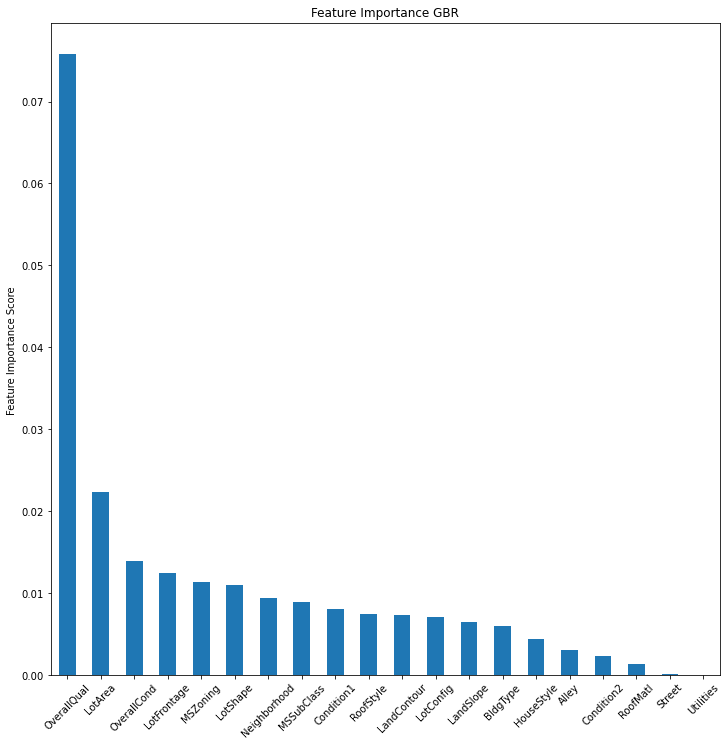

score test sans optimiser les paramètres : 0.42
Mean Absolute Error(MAE): 0.1529556005236053
Mean Squared Error(MSE): 0.04142698320631704
Root Mean Squared Error (RMSE): 0.20353619630502345
Explained Variance Score (EVS): 0.42449439980292514
R2: 0.4244315942264809
score train sans optimiser les paramètres : 1


In [24]:
#GradientBoostingRegressor test modèle
model1=GradientBoostingRegressor()
title2='Feature Importance GBR'

test_model(model,title2)

In [25]:
#GradientBoostingRegressor n_estimators
GBR=GradientBoostingRegressor()

optimise_n_estimator(GBR)

{'n_estimators': 50}
score test sans optimiser les paramètres : 0.44
Mean Absolute Error(MAE): 0.15486967910842445
Mean Squared Error(MSE): 0.04056539244485626
Root Mean Squared Error (RMSE): 0.20140852128163858
Explained Variance Score (EVS): 0.43644665670068894
R2: 0.43640215984873343
score train sans optimiser les paramètres : 0.63


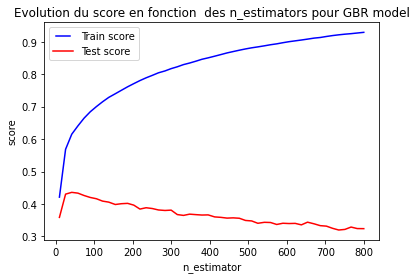

In [28]:
#GradientBoostingRegressor visualisation du score en fonction de n_estimators
GBR_op=GradientBoostingRegressor
title3='Evolution du score en fonction  des n_estimators pour GBR model'

visual_estimator(GBR_op,title3,n_esmistor)

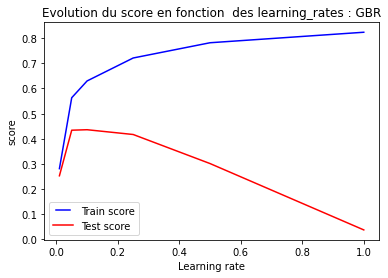

In [29]:
GBR_l=GradientBoostingRegressor
title4='Evolution du score en fonction  des learning_rates : GBR'
n=50
learning_rate='Learning rate'

visual_learning(GBR_l,title4,n,learning_rate)

In [31]:
#GradientBoostingRegressor hyperparametres
loss=['squared_error','absolute_error','huber','quantile'] 
max_features=['auto','sqrt','log2'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split=[2,6,10] # minimum sample number to split a node
min_samples_leaf=[1,3,4] # minimum sample number that can be stored in a leaf node
verbose=[0,1]
criterion=['friedman_mse','squared_error','mse','mae']

random_grid1={'loss':loss,'max_features':max_features,'max_depth':max_depth,'min_samples_split':min_samples_split,
             'min_samples_leaf':min_samples_leaf,'verbose':verbose,'criterion':criterion}

GBR_fi=GradientBoostingRegressor(learning_rate=0.05,n_estimators=50)

best_p1=opt_param(GBR_fi,random_grid1)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11.2min finished


score test sans optimiser les paramètres : 0.46
Mean Absolute Error(MAE): 0.14905067590249757
Mean Squared Error(MSE): 0.039215771325185986
Root Mean Squared Error (RMSE): 0.19802972333764945
Explained Variance Score (EVS): 0.4553692677826484
R2: 0.45515320605401055
score train sans optimiser les paramètres : 0.93
{'verbose': 0, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 100, 'loss': 'huber', 'criterion': 'mse'}


[8.37151885e-03 1.06191684e-02 1.23388323e-02 2.23481631e-02
 1.14543496e-04 3.48113533e-03 1.00301393e-02 7.18306950e-03
 7.16957829e-05 7.18832405e-03 6.07171611e-03 9.67479856e-03
 7.51048260e-03 2.21442823e-03 5.71029346e-03 4.05280791e-03
 7.52033765e-02 1.30168183e-02 7.29422093e-03 1.54813643e-03
 1.01968074e-02 8.54943259e-03 7.29107484e-03 8.03763743e-03
 4.40416366e-02 5.36854554e-03 5.63192487e-03 1.03692997e-02
 6.82332232e-03 7.96657322e-03 8.67031472e-03 1.22673512e-02
 3.52766929e-03 2.61299124e-03 1.08305218e-02 1.83194949e-02
 1.23311396e-02 8.72974614e-03 6.71214388e-03 8.02812802e-03
 2.11235388e-02 9.48373160e-03 1.55232495e-03 1.12842352e-01
 6.69403145e-03 1.97467528e-03 6.73102319e-02 5.83215019e-03
 2.39758690e-02 1.99818906e-03 3.03475535e-02 3.41444307e-02
 8.52858004e-03 6.60948793e-03 1.29299520e-02 7.14815051e-03
 1.39173383e-02 4.30137291e-02 2.50456030e-02 7.01818157e-03
 8.51239323e-03 6.78795914e-03 9.23081461e-03 1.58219091e-02
 5.06354864e-03 1.331111

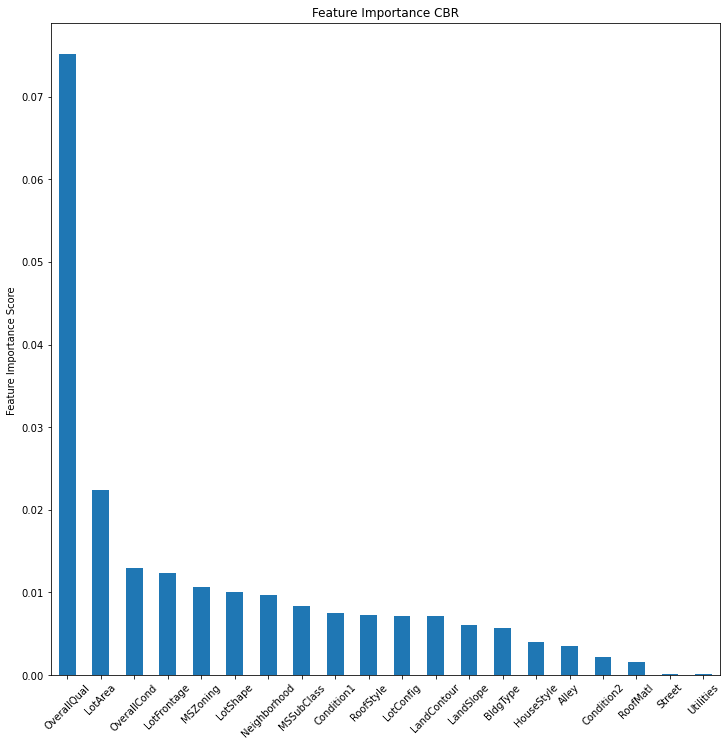

score test sans optimiser les paramètres : 0.44
Mean Absolute Error(MAE): 0.15069189094857097
Mean Squared Error(MSE): 0.039967217989030454
Root Mean Squared Error (RMSE): 0.19991802817412554
Explained Variance Score (EVS): 0.4447264658182464
R2: 0.4447129344035555
score train sans optimiser les paramètres : 1


In [32]:
#CatBoostingRegressor test modèle
model2=CatBoostRegressor()
title5='Feature Importance CBR'

test_model(model,title5)

In [33]:
#CatBoostingRegressor best n_estimators
CBR=CatBoostRegressor()

optimise_n_estimator(CBR)

Learning rate set to 0.059149
0:	learn: 0.2905641	total: 3.6ms	remaining: 2.7s
1:	learn: 0.2850820	total: 7.85ms	remaining: 2.93s
2:	learn: 0.2794791	total: 12.4ms	remaining: 3.1s
3:	learn: 0.2742014	total: 15.1ms	remaining: 2.82s
4:	learn: 0.2693715	total: 19.4ms	remaining: 2.9s
5:	learn: 0.2649348	total: 22.7ms	remaining: 2.81s
6:	learn: 0.2606318	total: 26.3ms	remaining: 2.79s
7:	learn: 0.2568492	total: 30ms	remaining: 2.78s
8:	learn: 0.2533971	total: 32.8ms	remaining: 2.7s
9:	learn: 0.2503323	total: 37.4ms	remaining: 2.77s
10:	learn: 0.2471606	total: 41.2ms	remaining: 2.77s
11:	learn: 0.2444641	total: 45.1ms	remaining: 2.78s
12:	learn: 0.2416182	total: 49.7ms	remaining: 2.82s
13:	learn: 0.2388152	total: 53.4ms	remaining: 2.81s
14:	learn: 0.2368616	total: 58.1ms	remaining: 2.85s
15:	learn: 0.2349330	total: 62.9ms	remaining: 2.88s
16:	learn: 0.2327851	total: 66.3ms	remaining: 2.86s
17:	learn: 0.2305387	total: 70.2ms	remaining: 2.85s
18:	learn: 0.2284449	total: 75ms	remaining: 2.88s
1

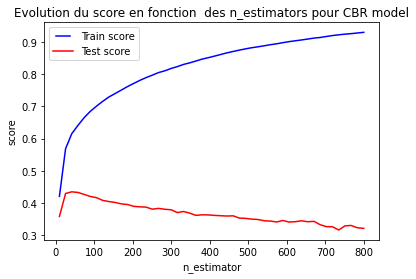

In [35]:
#CatBoostingRegressor visualisation du score en fonction de n_estimators
CBR_op=CatBoostRegressor
title6='Evolution du score en fonction  des n_estimators pour CBR model'

visual_estimator(GBR_op,title6,n_esmistor)

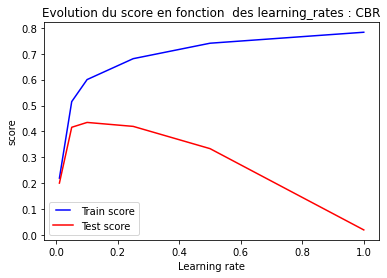

In [36]:
#CatBoostingRegressor visualisation du score en fonction de learning_rate
CBR_l=CatBoostRegressor
title7='Evolution du score en fonction  des learning_rates : CBR'
n1=35

visual_learning(GBR_l,title7,n1,learning_rate)

In [37]:
#CatBoostingRegressor hyperparametres
random_grid2= {'depth':[3,1,2,6,4,5,7,8,9,10],'iterations':[int(x) for x in np.linspace(20,800,num=50)],
              'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 'l2_leaf_reg':[3,1,5,10,100],
              'border_count':[32,5,10,20,50,100,200]}

CBR_fi=CatBoostRegressor()
best_p2=opt_param(CBR_fi,random_grid2)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.2min finished


0:	learn: 0.2937908	total: 4.32ms	remaining: 2.35s
1:	learn: 0.2909764	total: 7.99ms	remaining: 2.17s
2:	learn: 0.2878980	total: 11.3ms	remaining: 2.05s
3:	learn: 0.2848604	total: 15ms	remaining: 2.02s
4:	learn: 0.2821042	total: 18.6ms	remaining: 2.01s
5:	learn: 0.2795723	total: 22ms	remaining: 1.98s
6:	learn: 0.2767820	total: 25.5ms	remaining: 1.96s
7:	learn: 0.2743413	total: 29.3ms	remaining: 1.97s
8:	learn: 0.2721208	total: 33.2ms	remaining: 1.98s
9:	learn: 0.2699633	total: 37.1ms	remaining: 1.99s
10:	learn: 0.2677674	total: 40.9ms	remaining: 1.99s
11:	learn: 0.2657184	total: 52ms	remaining: 2.31s
12:	learn: 0.2635818	total: 55.8ms	remaining: 2.29s
13:	learn: 0.2616255	total: 59.5ms	remaining: 2.25s
14:	learn: 0.2597155	total: 63.4ms	remaining: 2.24s
15:	learn: 0.2577438	total: 67.8ms	remaining: 2.24s
16:	learn: 0.2560997	total: 71.4ms	remaining: 2.22s
17:	learn: 0.2543470	total: 74.9ms	remaining: 2.19s
18:	learn: 0.2527482	total: 78.6ms	remaining: 2.18s
19:	learn: 0.2511831	total: 

[8.35378771e-03 1.30984594e-02 1.40115438e-02 2.01560996e-02
 1.20802001e-04 3.69550056e-03 9.63480095e-03 7.59063254e-03
 6.56706178e-05 7.55012820e-03 5.51946886e-03 9.67083717e-03
 7.97921706e-03 2.37596441e-03 6.59462400e-03 3.53119072e-03
 7.15905007e-02 1.25312808e-02 8.00455161e-03 1.43194192e-03
 9.30039269e-03 8.81955858e-03 6.80087420e-03 7.94226063e-03
 5.09159855e-02 5.30622682e-03 4.73054007e-03 1.01836410e-02
 5.48033738e-03 7.89272553e-03 7.31154267e-03 1.27251521e-02
 3.22485949e-03 2.97859066e-03 1.05570317e-02 1.69684717e-02
 1.24353387e-02 8.65706180e-03 7.44862277e-03 7.15654722e-03
 1.99252364e-02 1.17615679e-02 1.73817440e-03 9.58432232e-02
 7.48719869e-03 2.05307079e-03 5.81513906e-02 5.58350920e-03
 2.35605465e-02 1.66102181e-03 3.62874436e-02 3.74346808e-02
 8.90909843e-03 9.04131864e-03 1.71568416e-02 7.15049406e-03
 1.97302695e-02 5.03292348e-02 1.95363313e-02 5.11493935e-03
 8.90557389e-03 6.47281516e-03 9.38953337e-03 1.57919180e-02
 5.01581537e-03 1.383319

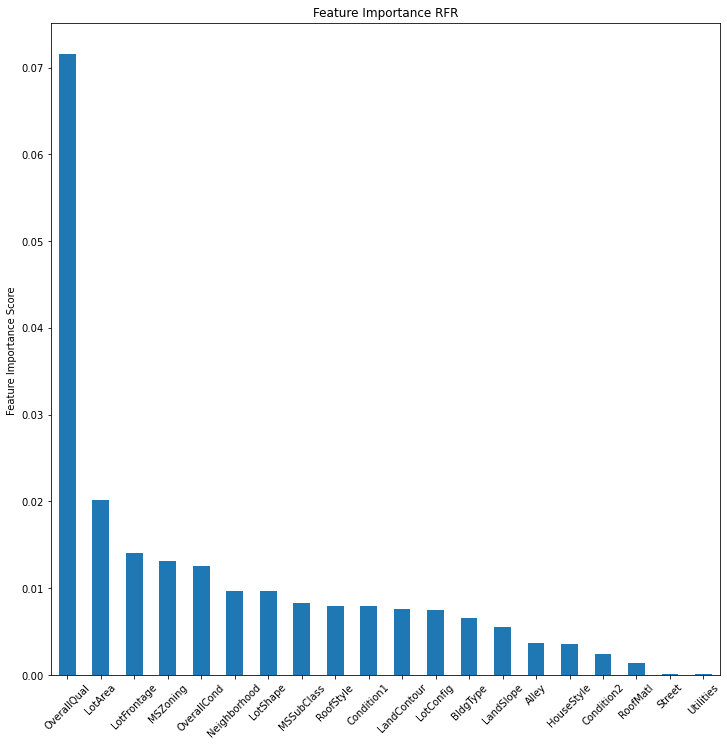

score test sans optimiser les paramètres : 0.42
Mean Absolute Error(MAE): 0.15335273623003814
Mean Squared Error(MSE): 0.0415353515202882
Root Mean Squared Error (RMSE): 0.20380223629854555
Explained Variance Score (EVS): 0.4230405673968526
R2: 0.42292597221683303
score train sans optimiser les paramètres : 1


In [38]:
#RandomForestRegressor test modèle
model3=RandomForestRegressor()
title8='Feature Importance RFR'

test_model(model,title8)

In [39]:
#RandomForestRegressor best n_estimators
RFR=RandomForestRegressor()

optimise_n_estimator(RFR)

{'n_estimators': 90}
score test sans optimiser les paramètres : 0.43
Mean Absolute Error(MAE): 0.15357748591553638
Mean Squared Error(MSE): 0.041090105775520046
Root Mean Squared Error (RMSE): 0.20270694555322974
Explained Variance Score (EVS): 0.4291175695409082
R2: 0.42911202207272914
score train sans optimiser les paramètres : 0.93


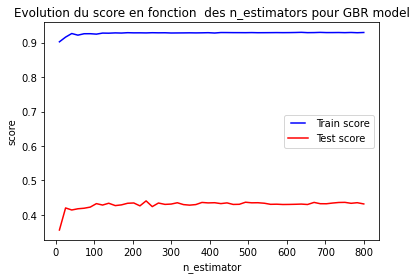

In [40]:
#RandomForestRegressor visualisation du score en fonction de n_estimators
GBR_op=RandomForestRegressor
title9='Evolution du score en fonction  des n_estimators pour GBR model'

visual_estimator(GBR_op,title9,n_esmistor)

In [41]:
#RandomForestRegressor hyperparametres
random_grid3={'max_features':['auto','sqrt','log2'],'max_depth':[int(x) for x in np.linspace(10, 120, num = 12)],
              'min_samples_split':[2,6,10],'min_samples_leaf':[1,3,4],'verbose':[0,1],
              'criterion':['friedman_mse','squared_error','mse','mae']}

RFR_fi=RandomForestRegressor(n_estimators=110)
best_p2=opt_param(RFR_fi,random_grid3)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


score test sans optimiser les paramètres : 0.45
Mean Absolute Error(MAE): 0.15263302552941432
Mean Squared Error(MSE): 0.03925606427158822
Root Mean Squared Error (RMSE): 0.19813143181128082
Explained Variance Score (EVS): 0.4546833829476232
R2: 0.4545933934601476
score train sans optimiser les paramètres : 0.93
{'verbose': 1, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'criterion': 'friedman_mse'}


[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    0.0s finished


[-2.93862036e-04 -1.82244702e-02  1.70478974e-04  4.71081147e-06
 -4.93588777e-02  1.53772888e-03 -2.12904598e-03 -7.14426306e-03
 -2.61805733e-01  6.83422647e-03 -2.68989633e-02  6.64714551e-05
 -7.11776100e-03 -5.12959416e-02  5.57548074e-03 -5.17473748e-03
  2.20112004e-02  2.29503197e-02 -3.32431628e-03  4.94793269e-02
  9.07269179e-03 -4.89137481e-03  4.65022104e-03 -1.47425085e-05
  2.04702840e-02 -5.84017095e-03 -4.05851108e-03 -6.49349764e-03
  4.52316776e-03  4.49897634e-03  3.19891889e-03  2.41528690e-05
 -5.65518880e-03  1.58161846e-05  1.06969261e-05  5.06659790e-05
 -1.02714894e-01  8.26454778e-03 -4.00301114e-02 -2.88589925e-02
  1.40580924e-05  6.16892986e-05  1.64119156e-05  9.21593026e-05
  2.01111753e-03  1.72622236e-02  1.86959337e-02  3.20319825e-03
  1.97721928e-02 -8.16494916e-02  1.53217291e-02  2.06719585e-02
 -2.21678789e-02  6.10709972e-03  3.70618782e-04 -3.13151713e-03
  6.51775191e-03 -2.54381379e-03  1.01910630e-04 -1.27135176e-02
  1.85854385e-02 -3.17018

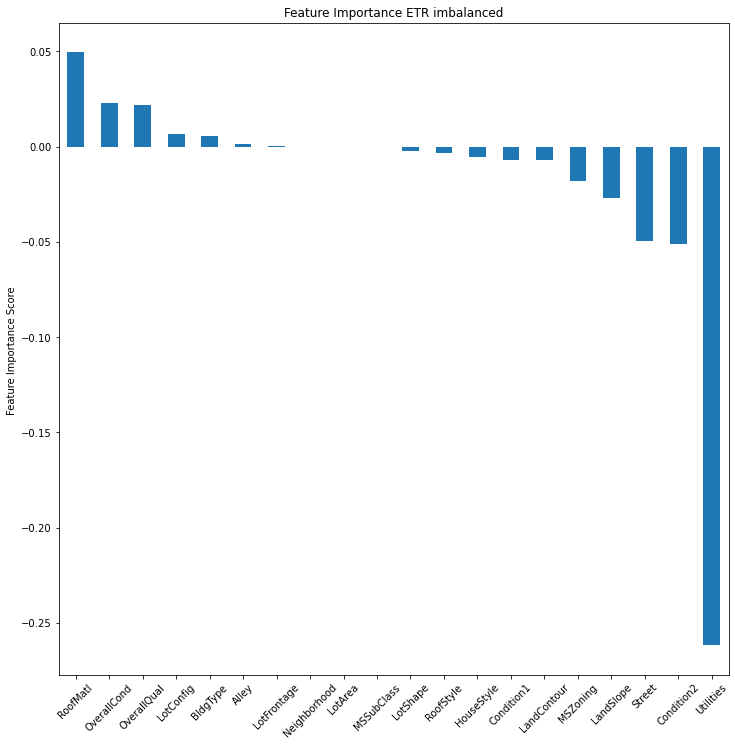

score test sans optimiser les paramètres : 0.37
Mean Absolute Error(MAE): 0.1560784131716925
Mean Squared Error(MSE): 0.04538140503249063
Root Mean Squared Error (RMSE): 0.21302911780432887
Explained Variance Score (EVS): 0.3695333851667396
R2: 0.3694905850076471
score train sans optimiser les paramètres : 0.54


In [42]:
#LinearRegression parametres par defaut
model4=LinearRegression()
model4.fit(X_train, y_train)
# feature importance
print(model4.coef_)
importance=model4.coef_
#plot Feature Importances
feat_imp = pd.Series(model4.coef_[:20], feats.columns[:20]).sort_values(ascending=False)
plt.figure(figsize=(12,12))
feat_imp.plot(kind='bar')
plt.xticks(rotation=45)
plt.ylabel('Feature Importance Score ')
plt.title('Feature Importance ETR imbalanced')
plt.show()

scoring(model4)